In [1]:
import omicverse as ov
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
adata = sc.read_h5ad('D:/scanpy/omicsverse_may07.h5ad')

In [8]:
adata.obs['Cell_type']

AAACCAAAGATAGAGC-1    CB-A2
AAACCATTCCAGGGAA-1      CHO
AAACCATTCTAACCGA-1    UN-N1
AAACCCGCATCGCTCG-1    UN-N1
AAACCCTGTAACGCTT-1     L1-5
                      ...  
TGTGTTAGTTTGCGTG-1    UN-G1
TGTGTTGAGCAACCCG-1     CB-B
TGTGTTGAGCCTACCC-1    GABA1
TGTGTTGAGCCTGACG-1     CB-B
TGTGTTGAGCGCATAC-1    UN-N1
Name: Cell_type, Length: 58068, dtype: category
Categories (43, object): ['A-G2', 'C2-C3', 'CB-A', 'CB-A2', ..., 'UN-G1', 'UN-G2', 'UN-G3', 'UN-N1']

In [9]:
adata.obs['Condition-Sex']

AAACCAAAGATAGAGC-1    Female-Control
AAACCATTCCAGGGAA-1    Female-Control
AAACCATTCTAACCGA-1    Female-Control
AAACCCGCATCGCTCG-1    Female-Control
AAACCCTGTAACGCTT-1    Female-Control
                           ...      
TGTGTTAGTTTGCGTG-1    Male-Capsaicin
TGTGTTGAGCAACCCG-1    Male-Capsaicin
TGTGTTGAGCCTACCC-1    Male-Capsaicin
TGTGTTGAGCCTGACG-1    Male-Capsaicin
TGTGTTGAGCGCATAC-1    Male-Capsaicin
Name: Condition-Sex, Length: 58068, dtype: category
Categories (4, object): ['Female-Capsaicin', 'Female-Control', 'Male-Capsaicin', 'Male-Control']

In [10]:
Female = adata[adata.obs['Condition-Sex'].isin(['Female-Control','Female-Capsaicin'])]
Female

View of AnnData object with n_obs × n_vars = 29412 × 11335
    obs: 'Sample', 'condition', 'Sex', 'Condition-Sex', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'leiden', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.30', 'leiden_res_0.40', 'leiden_res_0.50', 'leiden_res_0.60', 'leiden_res_0.70', 'leiden_res_0.80', 'leiden_res_0.90', 'leiden_res_1.00', 'leiden_res_1.10', 'leiden_res_1.20', 'leiden_res_1.30', 'leiden_res_1.40', 'leiden_res_1.50', 'leiden_res_1.60', 'leiden_res_1.70', 'leiden_res_1.80', 'leiden_res_1.90', 'leiden_res_2.00', 'leiden_res_2.20', 'leiden_res_2.40', 'leiden_res_2.60', 'leiden_res_2.80', 'leiden_res_3.00', 'leiden_res_3.20', 'leiden_res_3.40', 'leiden_res_3.60', 'leiden_res_3.80', 'leiden_res_4.00', 'leiden_res_4.20', 'leiden_res_4.40', 'leiden_res_4.60', 'leiden_res_4.80', 'leiden_res_5.00', 'temp_density', 'Cell_type', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells', 'percent_cells', 'robust', 'me

In [11]:
Male = adata[adata.obs['Condition-Sex'].isin(['Male-Control','Male-Capsaicin'])]
Male

View of AnnData object with n_obs × n_vars = 28656 × 11335
    obs: 'Sample', 'condition', 'Sex', 'Condition-Sex', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'leiden', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.30', 'leiden_res_0.40', 'leiden_res_0.50', 'leiden_res_0.60', 'leiden_res_0.70', 'leiden_res_0.80', 'leiden_res_0.90', 'leiden_res_1.00', 'leiden_res_1.10', 'leiden_res_1.20', 'leiden_res_1.30', 'leiden_res_1.40', 'leiden_res_1.50', 'leiden_res_1.60', 'leiden_res_1.70', 'leiden_res_1.80', 'leiden_res_1.90', 'leiden_res_2.00', 'leiden_res_2.20', 'leiden_res_2.40', 'leiden_res_2.60', 'leiden_res_2.80', 'leiden_res_3.00', 'leiden_res_3.20', 'leiden_res_3.40', 'leiden_res_3.60', 'leiden_res_3.80', 'leiden_res_4.00', 'leiden_res_4.20', 'leiden_res_4.40', 'leiden_res_4.60', 'leiden_res_4.80', 'leiden_res_5.00', 'temp_density', 'Cell_type', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells', 'percent_cells', 'robust', 'me

In [13]:
Female.var_names = Female.var['gene_names']
Male.var_names = Male.var['gene_names']

In [184]:
from statsmodels.stats.multitest import multipletests

def adjust_pvalues_FDR(df, de_pval_col='de_pval', dv_pval_col='dv_pval'):
    N = len(df)
    df['de_padj_fdr'] = multipletests(df[de_pval_col], method='fdr_bh')[1]
    df['dv_padj_fdr'] = multipletests(df[dv_pval_col], method='fdr_bh')[1]

    return df


In [183]:
def categorize(row):
    if row['de_padj_fdr'] < 0.2: #and row['dv_padj_fdr'] < 0.05:
        if row['log2FC'] > 0.25:
            return 'up'
        elif row['log2FC'] < -0.25:
            return 'down'
    return 'normal'



### FEMALE

In [16]:
DegFemaleObject =ov.single.DEG(
    Female,
    condition='Condition-Sex',
    ctrl_group='Female-Control',
    test_group='Female-Capsaicin',
    method='memento-de',
)
DegFemaleObject.run(
    celltype_key='Cell_type',
    celltype_group=None,
    capture_rate=0.07, 
    num_cpus=12,
    num_boot=5000
)


✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-A2', 'CHO', 'UN-N1', 'L1-5', 'KC', ..., 'OL-CHO', 'HEMO', 'GABA2', 'GLU2', 'OCT']
Length: 43
Categories (43, object): ['A-G2', 'C2-C3', 'CB-A', 'CB-A2', ..., 'UN-G1', 'UN-G2', 'UN-G3', 'UN-N1']
Total cells: 29412 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 9412/9412 [00:34<00:00, 274.23it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   49.4s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  2.6min
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 4115 out of 4115 | elapsed:  5.8min finished


✅ memento-de DEG analysis completed


In [64]:
ALL_DEGS_FEMALE = DegFemaleObject.get_results()

In [57]:
ALL_DEGS_FEMALE['log2FC'] = ALL_DEGS_FEMALE['de_coef'] / np.log(2)
ALL_DEGS_FEMALE

,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,log2FC,de_padj_fdr,dv_padj_fdr,sig
gene,,,,,,,,,,,
Nep3,stim,0.235562,0.026289,1.648284e-19,0.128140,0.164631,8.084707e-01,0.339845,7.859431e-19,1.000000e+00,normal
CG33217,stim,0.277068,0.042367,3.282184e-11,0.075018,0.111021,7.052552e-01,0.399725,1.040538e-10,1.000000e+00,normal
Vps11,stim,0.060974,0.026505,1.071893e-02,-0.021908,0.058988,3.553308e-01,0.087967,1.704343e-02,7.709499e-01,normal
RpL10,stim,0.340687,0.026253,3.988470e-38,-0.106016,0.178368,2.763507e-01,0.491508,3.738623e-37,6.850500e-01,normal
G9a,stim,0.062051,0.021137,1.917988e-03,-0.084569,0.041533,2.089024e-02,0.089521,3.327370e-03,1.528422e-01,normal
...,...,...,...,...,...,...,...,...,...,...,...
CG4629,stim,-0.323173,0.028511,8.143660e-19,-0.423249,0.059968,8.466493e-13,-0.466240,3.727604e-18,2.357518e-10,down
S,stim,0.112959,0.025307,4.049390e-06,-0.114902,0.106130,7.901269e-01,0.162966,8.910824e-06,1.000000e+00,normal
GABA-B-R3,stim,-0.353814,0.038545,3.028615e-20,-0.064866,0.112804,7.886169e-01,-0.510445,1.494335e-19,1.000000e+00,normal


In [27]:
ALL_DEGS_FEMALE = adjust_pvalues_FDR(ALL_DEGS_FEMALE)

In [185]:
ALL_DEGS_FEMALE['sig'] = ALL_DEGS_FEMALE.apply(categorize, axis=1)
ALL_DEGS_FEMALE

,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,log2FC,de_padj_fdr,dv_padj_fdr,sig
gene,,,,,,,,,,,
Nep3,stim,0.235562,0.026289,1.648284e-19,0.128140,0.164631,8.084707e-01,0.339845,7.859431e-19,1.000000e+00,up
CG33217,stim,0.277068,0.042367,3.282184e-11,0.075018,0.111021,7.052552e-01,0.399725,1.040538e-10,1.000000e+00,up
Vps11,stim,0.060974,0.026505,1.071893e-02,-0.021908,0.058988,3.553308e-01,0.087967,1.704343e-02,7.709499e-01,normal
RpL10,stim,0.340687,0.026253,3.988470e-38,-0.106016,0.178368,2.763507e-01,0.491508,3.738623e-37,6.850500e-01,up
G9a,stim,0.062051,0.021137,1.917988e-03,-0.084569,0.041533,2.089024e-02,0.089521,3.327370e-03,1.528422e-01,normal
...,...,...,...,...,...,...,...,...,...,...,...
CG4629,stim,-0.323173,0.028511,8.143660e-19,-0.423249,0.059968,8.466493e-13,-0.466240,3.727604e-18,2.357518e-10,down
S,stim,0.112959,0.025307,4.049390e-06,-0.114902,0.106130,7.901269e-01,0.162966,8.910824e-06,1.000000e+00,normal
GABA-B-R3,stim,-0.353814,0.038545,3.028615e-20,-0.064866,0.112804,7.886169e-01,-0.510445,1.494335e-19,1.000000e+00,down


In [96]:
DegMaleObject = ov.single.DEG(
    Male,
    condition='Condition-Sex',
    ctrl_group='Male-Control',
    test_group='Male-Capsaicin',
    method='memento-de',
)

DegMaleObject.run(
    celltype_key='Cell_type',
    celltype_group=None,
    capture_rate=0.07, 
    num_cpus=12,
    num_boot=5000
)


✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC3', 'PRC2', 'CB-A', 'PRC1', 'L1-5', ..., 'HEMO', 'GABA2', 'MUS', 'T2-T3', 'GLU2']
Length: 43
Categories (43, object): ['A-G2', 'C2-C3', 'CB-A', 'CB-A2', ..., 'UN-G1', 'UN-G2', 'UN-G3', 'UN-N1']
Total cells: 28656 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 8656/8656 [00:10<00:00, 864.94it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   20.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   27.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   36.8s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   50.3s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 3883 out of 3883 | elapsed:  2.4min finished


✅ memento-de DEG analysis completed


In [97]:
ALL_DEGS_Male = DegMaleObject.get_results()

In [98]:
ALL_DEGS_Male = adjust_pvalues_FDR(ALL_DEGS_Male)

In [101]:
ALL_DEGS_Male['log2FC'] = ALL_DEGS_Male['de_coef'] / np.log(2)


In [187]:
ALL_DEGS_Male['sig'] = ALL_DEGS_Male.apply(categorize, axis=1)
#ALL_DEGS_Male.set_index('gene', inplace=True)
ALL_DEGS_Male

,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_padj_fdr,dv_padj_fdr,log2FC,sig
gene,,,,,,,,,,,
Nep3,stim,-0.014996,0.027448,4.046084e-01,-0.087137,0.078052,0.873824,0.525977,0.999931,-0.021634,normal
CG33217,stim,-0.008366,0.040088,6.102681e-01,0.351262,0.107098,0.001103,0.714404,0.060306,-0.012069,normal
Vps11,stim,-0.018809,0.024872,8.571263e-01,0.014701,0.059475,0.404731,0.909350,0.995295,-0.027136,normal
RpL10,stim,-0.223186,0.025517,2.756883e-07,-0.105707,0.085428,0.892736,0.000002,0.999931,-0.321990,down
G9a,stim,0.005752,0.021094,8.963942e-01,-0.038401,0.049505,0.789955,0.936285,0.999931,0.008298,normal
...,...,...,...,...,...,...,...,...,...,...,...
CG4629,stim,0.095835,0.029490,9.156249e-04,0.140821,0.076762,0.233379,0.002907,0.887464,0.138260,normal
S,stim,0.054111,0.025349,2.088503e-02,0.162422,0.098286,0.096405,0.045637,0.684334,0.078065,normal
GABA-B-R3,stim,0.065652,0.039542,7.372137e-02,0.015390,0.090310,0.764075,0.130570,0.999931,0.094716,normal


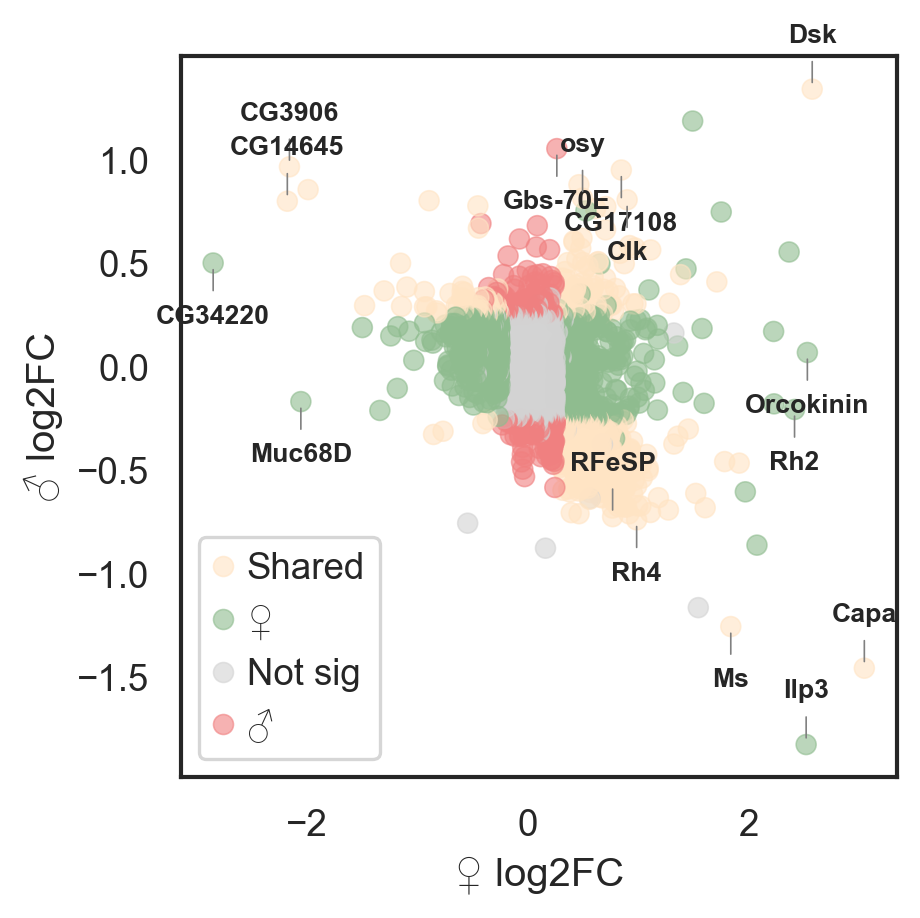

In [5]:
import seaborn as sns
sns.set(style="white")

merged_df = ALL_DEGS_FEMALE[['log2FC', 'sig']].rename(columns={'log2FC': 'Female_LFC', 'sig': 'Female_sig'}).merge(
    ALL_DEGS_Male[['log2FC', 'sig']].rename(columns={'log2FC': 'Male_LFC', 'sig': 'Male_sig'}),
    left_index=True, right_index=True
)

def classify_deg(row):
    if row['Female_sig'] != 'normal' and row['Male_sig'] != 'normal':
        return 'Shared'
    elif row['Female_sig'] != 'normal':
        return '♀'
    elif row['Male_sig'] != 'normal':
        return '♂'
    else:
        return 'Not sig'

merged_df['DE_Class'] = merged_df.apply(classify_deg, axis=1)
color_map = {
    'Not sig': 'lightgray',
    'Shared': 'bisque',
    '♀': 'darkseagreen',
    '♂': 'lightcoral'
}
plt.figure(figsize=(4, 4))
sns.scatterplot(
    data=merged_df,
    x='Female_LFC', y='Male_LFC',
    hue='DE_Class',
    palette=color_map,
    edgecolor=None,
    alpha=0.6
)
genes_to_label = [
    "Dsk",
    "Gbs-70E",
    "CG3906",
    "CG17108",
    "osy",
    "Clk",
    "RFeSP",
    "Rh4",
    "Trhn",
    "Ms",
    "Capa",
    "Orcokinin",
    "Ilp3",
    "Rh2",
    "Yp3",
    "Muc68D",
    "CG14645",
    "CG34220"
]

offset = 0.2 
for i, gene in enumerate(genes_to_label):
    if gene in merged_df.index:
        row = merged_df.loc[gene]
        x = row['Female_LFC']
        y = row['Male_LFC']
        
        # Alternate label positions (above or below)
        y_offset = offset if i % 2 == 0 else -offset
        
        plt.annotate(
            gene,
            xy=(x, y),  # point to annotate
            xytext=(x, y + y_offset),  # label position
            textcoords='data',
            fontsize=8,
            fontweight='bold',
            ha='center',
            va='bottom' if y_offset > 0 else 'top',
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
        )

#plt.axhline(0.25, color='silver', lw=0.5)
#plt.axvline(0.25, color='silver', lw=0.5)
#plt.axhline(-0.25, color='silver', lw=0.5)
#plt.axvline(-0.25, color='silver', lw=0.5)

plt.xlabel("♀ log2FC")
plt.ylabel("♂ log2FC")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


In [8]:
merged_df

,Female_LFC,Female_sig,Male_LFC,Male_sig,DE_Class
0,0.339845,up,-0.021634,normal,Female only
1,0.399725,up,-0.012069,normal,Female only
2,0.087967,normal,-0.027136,normal,Not DEG
3,0.491508,up,1.341720,up,Shared
4,0.089521,normal,0.008298,normal,Not DEG
...,...,...,...,...,...
3878,-0.111354,normal,0.138260,normal,Not DEG
3879,0.067537,normal,0.078065,normal,Not DEG
3880,-0.244945,normal,0.094716,normal,Not DEG
3881,-0.490222,down,0.034229,normal,Female only


In [192]:
#merged_df.sort_values('DE_Class').to_csv("C:/Users/Student/Desktop/COMMON.csv")

In [193]:
ALL_DEGS_Male.to_csv("C:/Users/Student/Desktop/MaleDegs.csv")
ALL_DEGS_FEMALE.to_csv("C:/Users/Student/Desktop/FemaleDegs.csv")

In [3]:
ALL_DEGS_Male = pd.read_csv(
    "C:/Users/Student/Desktop/GerardoIga/2025/Drosophila/Manuscript_1/Tables/MaleDegs_snRNA.csv",
    index_col=0
)

ALL_DEGS_FEMALE = pd.read_csv(
    "C:/Users/Student/Desktop/GerardoIga/2025/Drosophila/Manuscript_1/Tables/FemaleDegs_snRNA.csv",
    index_col=0
)


### ENRICHMENT

In [37]:
pathway_dict=ov.utils.geneset_prepare('genesets/KEGG_2019_fly.txt',organism='FLY')
GOBio=ov.utils.geneset_prepare('genesets/GO_Biological_Process_AutoRIF.txt',organism='FLY')
GOMol=ov.utils.geneset_prepare('genesets/GO_Molecular_Function_2018.txt', organism='FLY')

In [194]:
#UPfemale
UPfemale = ALL_DEGS_FEMALE[ALL_DEGS_FEMALE['sig'] == 'up' ].index.tolist()
#DownFemale
Downfemale = ALL_DEGS_FEMALE[ALL_DEGS_FEMALE['sig'] == 'down'].index.tolist()
#Sigfemale
Sigfemale = ALL_DEGS_FEMALE[ALL_DEGS_FEMALE['sig'].isin(['up', 'down'])].index.tolist()

In [195]:
#UPmale
UPmale = ALL_DEGS_Male[ALL_DEGS_Male['sig'] == 'up' ].index.tolist()
#Downmale
Downmale = ALL_DEGS_Male[ALL_DEGS_Male['sig'] == 'down'].index.tolist()
#Sigmale
Sigmale = ALL_DEGS_Male[ALL_DEGS_Male['sig'].isin(['up', 'down'])].index.tolist()

In [40]:
FemaleDEGs_background = adata_raw.var["gene_names"].tolist()

In [196]:
UPFenrKegg = ov.bulk.geneset_enrichment(gene_list=UPfemale,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
UPFenrBIO = ov.bulk.geneset_enrichment(gene_list=UPfemale,
                                pathways_dict=GOBio, 
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
DownFenrKegg = ov.bulk.geneset_enrichment(gene_list=Downfemale,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
DownFenrBIO = ov.bulk.geneset_enrichment(gene_list=Downfemale,
                                pathways_dict=GOBio, 
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')

In [197]:
UPMenrKegg = ov.bulk.geneset_enrichment(gene_list=UPmale,
                                pathways_dict=pathway_dict, 
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
UPMenrBIO = ov.bulk.geneset_enrichment(gene_list=UPmale,
                                pathways_dict=GOBio,
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
DownMenrKegg = ov.bulk.geneset_enrichment(gene_list=Downmale,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
DownMenrBIO = ov.bulk.geneset_enrichment(gene_list=Downmale,
                                pathways_dict=GOBio,
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')

In [198]:
FenrKegg = ov.bulk.geneset_enrichment(gene_list=Sigfemale,
                                pathways_dict=pathway_dict, 
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
FenrBIO = ov.bulk.geneset_enrichment(gene_list=Sigfemale,
                                pathways_dict=GOBio, 
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')


In [199]:
MenrKegg = ov.bulk.geneset_enrichment(gene_list=Sigmale,
                                pathways_dict=pathway_dict, 
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')
MenrBIO = ov.bulk.geneset_enrichment(gene_list=Sigmale,
                                pathways_dict=GOBio,
                                pvalue_type='auto', background=FemaleDEGs_background,
                                organism='fly')


<Axes: title={'center': 'KEGG Female'}, xlabel='Fractions of genes'>

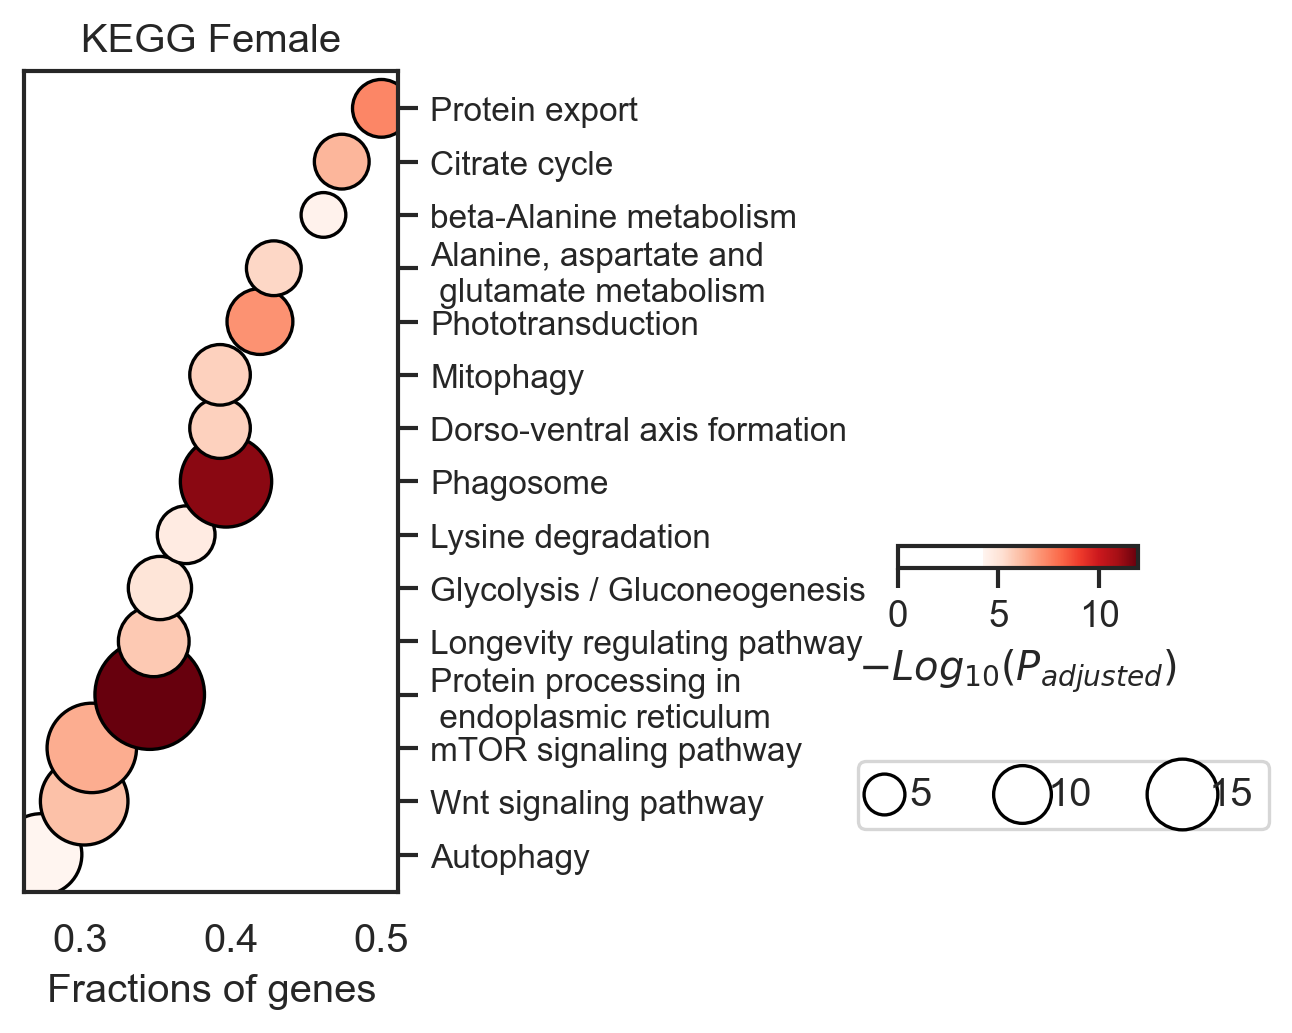

In [233]:
ov.bulk.geneset_plot(FenrKeggC,figsize=(2,4.5),fig_title='KEGG Female',
                    cax_loc=[2, 0.45, 0.5, 0.02], 
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=30,  num=15,
                     custom_ticks=[0, 5, 10],text_knock=3,
                    cmap='Reds')

<Axes: title={'center': 'KEGG MALE'}, xlabel='Fractions of genes'>

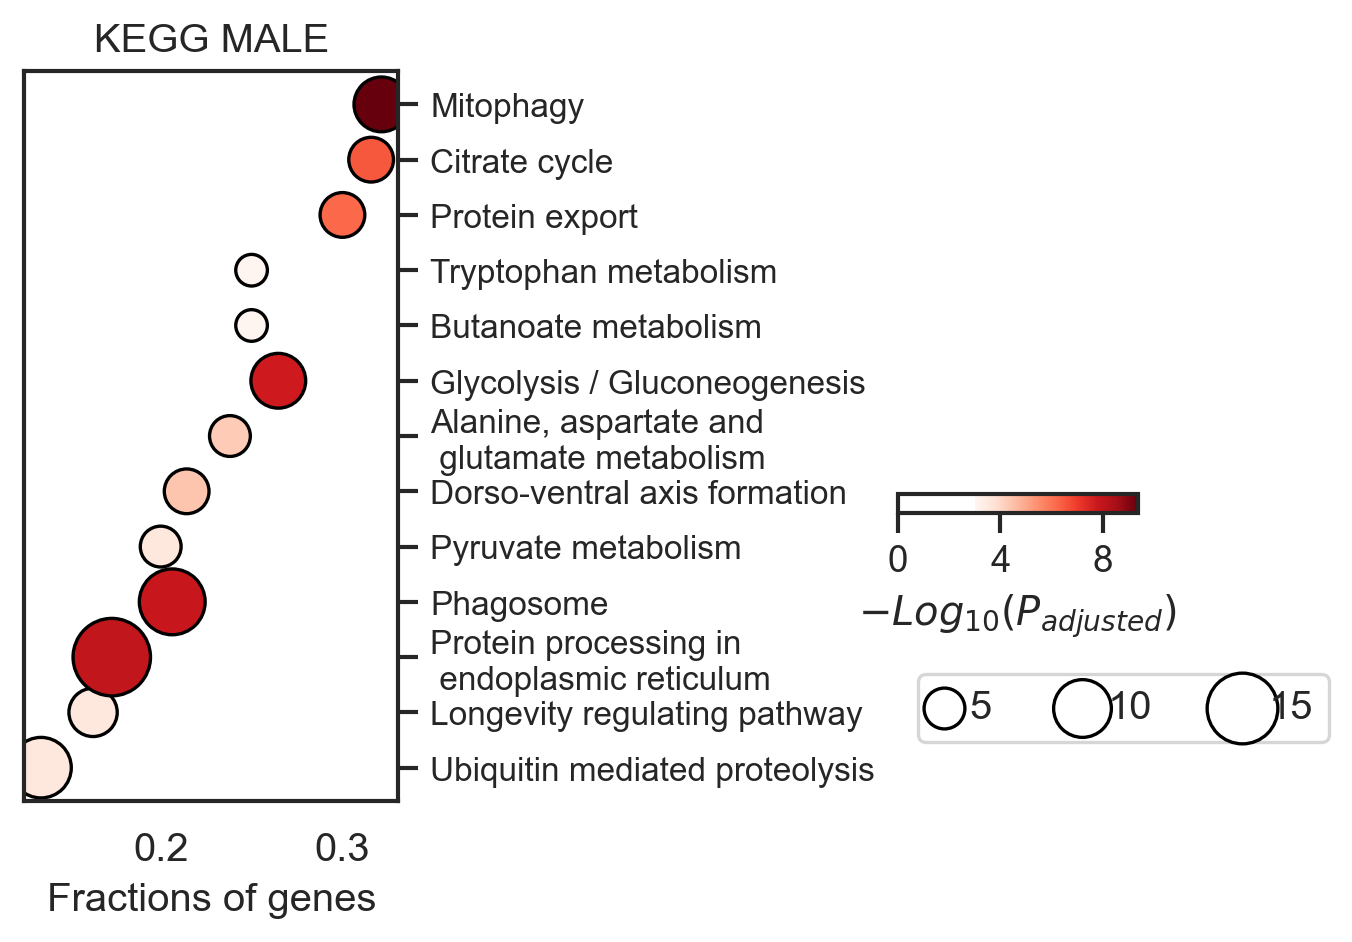

In [230]:
ov.bulk.geneset_plot(MenrKeggC,figsize=(2,4),fig_title='KEGG MALE', 
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    bbox_to_anchor_used=(-0.0, -13),node_diameter=30, num=15,
                     custom_ticks=[0, 4, 8],text_knock=3,
                    cmap='Reds')

### Pseudo-bulk for each cell-type

In [254]:
cell_types = Female.obs['Cell_type'].unique().tolist()
all_resultsFEMALE = {}

for ct in cell_types:
    print(f"Running DEG for cell type: {ct}")
    subset = Female[Female.obs['Cell_type'] == ct, :]
    group_counts = subset.obs['Condition-Sex'].value_counts()

    if ('Female-Control' not in group_counts) or ('Female-Capsaicin' not in group_counts):
        print(f"Skipping {ct}: one of the groups missing")
        continue

    if (group_counts['Female-Control'] < 20) or (group_counts['Female-Capsaicin'] < 20):
        print(f"Skipping {ct}: not enough cells per group (Control={group_counts['Female-Control']}, Capsaicin={group_counts['Female-Capsaicin']})")
        continue
    deg = ov.single.DEG(
        subset,
        condition='Condition-Sex',
        ctrl_group='Female-Control',
        test_group='Female-Capsaicin',
        method='memento-de',
    )

    deg.run( 
        celltype_key="Cell_type",
        capture_rate=0.07,
        num_cpus=12,
        num_boot=5000
    )
    resultFemales = deg.get_results()
    all_resultsFEMALE[ct] = resultFemales
with pd.ExcelWriter("Female_DEG_by_CellType.xlsx") as writer:
    for ct, res in all_resultsFEMALE.items():
        res.to_excel(writer, sheet_name=ct)


Running DEG for cell type: CB-A2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-A2']
Categories (1, object): ['CB-A2']
Total cells: 526 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 526/526 [00:00<00:00, 642.48it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   15.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   18.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   21.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   25.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   30.2s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:   37.5s
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:   45.5s
[Parallel(n_jobs=12)]: Done 2895 out of 2895 | elapsed:   50.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CHO
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CHO']
Categories (1, object): ['CHO']
Total cells: 2272 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2272/2272 [00:04<00:00, 548.98it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   12.2s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   24.2s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   42.5s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 4845 out of 4845 | elapsed:  1.7min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-N1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-N1']
Categories (1, object): ['UN-N1']
Total cells: 1066 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:01<00:00, 830.11it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.7s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   16.6s
[Parallel(n_jobs=12)]: Done 1255 out of 1278 | elapsed:   25.6s remaining:    0.4s
[Parallel(n_jobs=12)]: Done 1278 out of 1278 | elapsed:   25.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: L1-5
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['L1-5']
Categories (1, object): ['L1-5']
Total cells: 439 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 709.72it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   12.4s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   26.3s
[Parallel(n_jobs=12)]: Done 4555 out of 4578 | elapsed:   41.8s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 4578 out of 4578 | elapsed:   42.0s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: KC
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['KC']
Categories (1, object): ['KC']
Total cells: 744 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 744/744 [00:01<00:00, 630.78it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.8s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   19.5s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   33.7s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:   49.6s
[Parallel(n_jobs=12)]: Done 3786 out of 3809 | elapsed:   53.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 3809 out of 3809 | elapsed:   53.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: C2-C3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['C2-C3']
Categories (1, object): ['C2-C3']
Total cells: 289 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 561.69it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    7.2s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   20.9s
[Parallel(n_jobs=12)]: Done 1989 out of 2012 | elapsed:   26.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2012 out of 2012 | elapsed:   26.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-G1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-G1']
Categories (1, object): ['UN-G1']
Total cells: 2050 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2050/2050 [00:03<00:00, 632.19it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   13.5s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   26.8s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   46.6s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 4828 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 5708 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 6558 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 6934 out of 6934 | elapsed:  2.6min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: Tm1-Y8
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['Tm1-Y8']
Categories (1, object): ['Tm1-Y8']
Total cells: 987 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 987/987 [00:01<00:00, 809.84it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.1s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.9s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   20.6s
[Parallel(n_jobs=12)]: Done 2295 out of 2295 | elapsed:   31.7s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CB-A
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-A']
Categories (1, object): ['CB-A']
Total cells: 2839 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2839/2839 [00:03<00:00, 803.48it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    6.3s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   19.2s
[Parallel(n_jobs=12)]: Done 1484 tasks      | elapsed:   38.9s
[Parallel(n_jobs=12)]: Done 1934 tasks      | elapsed:   53.2s
[Parallel(n_jobs=12)]: Done 2484 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 2655 out of 2655 | elapsed:  1.3min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: Pn-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['Pn-G']
Categories (1, object): ['Pn-G']
Total cells: 304 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 304/304 [00:00<00:00, 820.20it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    5.9s
[Parallel(n_jobs=12)]: Done 1413 out of 1413 | elapsed:   15.5s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: T4-T5
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['T4-T5']
Categories (1, object): ['T4-T5']
Total cells: 727 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 944.42it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.6s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   27.1s
[Parallel(n_jobs=12)]: Done 2352 out of 2375 | elapsed:   42.3s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 2375 out of 2375 | elapsed:   42.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GLU1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['GLU1']
Categories (1, object): ['GLU1']
Total cells: 1010 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1010/1010 [00:01<00:00, 816.27it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.1s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   10.1s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   20.9s
[Parallel(n_jobs=12)]: Done 2290 out of 2313 | elapsed:   32.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2313 out of 2313 | elapsed:   32.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GABA1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['GABA1']
Categories (1, object): ['GABA1']
Total cells: 1719 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1719/1719 [00:02<00:00, 783.23it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.1s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   15.5s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   31.6s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   55.7s
[Parallel(n_jobs=12)]: Done 2975 out of 2998 | elapsed:  1.1min remaining:    0.4s
[Parallel(n_jobs=12)]: Done 2998 out of 2998 | elapsed:  1.1min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CHO2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CHO2']
Categories (1, object): ['CHO2']
Total cells: 1419 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1419/1419 [00:01<00:00, 761.31it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.5s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   16.6s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   34.5s
[Parallel(n_jobs=12)]: Done 2009 out of 2032 | elapsed:   45.5s remaining:    0.4s
[Parallel(n_jobs=12)]: Done 2032 out of 2032 | elapsed:   45.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: T2-T3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['T2-T3']
Categories (1, object): ['T2-T3']
Total cells: 371 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 371/371 [00:00<00:00, 716.71it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   11.3s
[Parallel(n_jobs=12)]: Done 1162 out of 1162 | elapsed:   16.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PoxnN
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PoxnN']
Categories (1, object): ['PoxnN']
Total cells: 262 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 745.05it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   12.7s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   27.6s
[Parallel(n_jobs=12)]: Done 3564 out of 3587 | elapsed:   33.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 3587 out of 3587 | elapsed:   33.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC1']
Categories (1, object): ['PRC1']
Total cells: 2164 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2164/2164 [00:02<00:00, 793.64it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   11.7s
[Parallel(n_jobs=12)]: Done 1095 out of 1095 | elapsed:   15.7s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CHO3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CHO3']
Categories (1, object): ['CHO3']
Total cells: 277 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 619.98it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    8.9s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   18.0s
[Parallel(n_jobs=12)]: Done 2327 out of 2350 | elapsed:   28.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2350 out of 2350 | elapsed:   28.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CB-B
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-B']
Categories (1, object): ['CB-B']
Total cells: 2747 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2747/2747 [00:03<00:00, 687.40it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    6.0s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   17.9s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   36.1s
[Parallel(n_jobs=12)]: Done 2210 tasks      | elapsed:   57.9s
[Parallel(n_jobs=12)]: Done 2760 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 3410 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 3832 out of 3832 | elapsed:  1.8min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CTX-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CTX-G']
Categories (1, object): ['CTX-G']
Total cells: 343 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 766.48it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   17.1s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   29.2s
[Parallel(n_jobs=12)]: Done 3515 tasks      | elapsed:   47.8s
[Parallel(n_jobs=12)]: Done 4166 tasks      | elapsed:   58.6s
[Parallel(n_jobs=12)]: Done 4916 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 5770 out of 5770 | elapsed:  1.4min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC2']
Categories (1, object): ['PRC2']
Total cells: 1219 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1219/1219 [00:01<00:00, 961.38it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.8s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   13.8s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   27.9s
[Parallel(n_jobs=12)]: Done 2061 out of 2084 | elapsed:   38.0s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 2084 out of 2084 | elapsed:   38.5s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: EN-G2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['EN-G2']
Categories (1, object): ['EN-G2']
Total cells: 749 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 815.93it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done 1367 out of 1390 | elapsed:   12.9s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 1390 out of 1390 | elapsed:   13.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC5
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC5']
Categories (1, object): ['PRC5']
Total cells: 200 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1002.12it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 732 out of 755 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 755 out of 755 | elapsed:    6.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PD-N2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PD-N2']
Categories (1, object): ['PD-N2']
Total cells: 105 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 588.25it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:    8.0s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   17.4s
[Parallel(n_jobs=12)]: Done 4352 out of 4375 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 4375 out of 4375 | elapsed:   25.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC3']
Categories (1, object): ['PRC3']
Total cells: 393 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 867.50it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   11.1s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   22.2s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   37.7s
[Parallel(n_jobs=12)]: Done 3519 out of 3542 | elapsed:   55.6s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 3542 out of 3542 | elapsed:   55.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: SPn-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['SPn-G']
Categories (1, object): ['SPn-G']
Total cells: 289 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 752.18it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:    8.6s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   18.4s
[Parallel(n_jobs=12)]: Done 3725 out of 3725 | elapsed:   23.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: DOP
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['DOP']
Categories (1, object): ['DOP']
Total cells: 247 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 782.03it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   16.3s
[Parallel(n_jobs=12)]: Done 2386 out of 2409 | elapsed:   24.6s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 2409 out of 2409 | elapsed:   24.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: A-G2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['A-G2']
Categories (1, object): ['A-G2']
Total cells: 530 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 701.36it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   10.3s
[Parallel(n_jobs=12)]: Done 1125 out of 1148 | elapsed:   14.4s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 1148 out of 1148 | elapsed:   14.6s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC4
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC4']
Categories (1, object): ['PRC4']
Total cells: 220 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 731.79it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   10.7s
[Parallel(n_jobs=12)]: Done 2129 out of 2129 | elapsed:   14.7s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PD-N
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PD-N']
Categories (1, object): ['PD-N']
Total cells: 258 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 536.52it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 560 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 1560 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 2960 tasks      | elapsed:   27.7s
[Parallel(n_jobs=12)]: Done 4544 out of 4544 | elapsed:   43.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-G2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-G2']
Categories (1, object): ['UN-G2']
Total cells: 277 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 713.21it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   12.0s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   25.8s
[Parallel(n_jobs=12)]: Done 4449 out of 4449 | elapsed:   39.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: EN-G1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['EN-G1']
Categories (1, object): ['EN-G1']
Total cells: 970 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 970/970 [00:01<00:00, 691.41it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.9s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   19.9s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   34.9s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:   55.9s
[Parallel(n_jobs=12)]: Done 4444 out of 4467 | elapsed:  1.2min remaining:    0.3s
[Parallel(n_jobs=12)]: Done 4467 out of 4467 | elapsed:  1.2min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-G3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-G3']
Categories (1, object): ['UN-G3']
Total cells: 180 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 598.67it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:    9.7s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   20.0s
[Parallel(n_jobs=12)]: Done 3371 out of 3371 | elapsed:   22.6s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: MUS
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['MUS']
Categories (1, object): ['MUS']
Total cells: 143 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 616.01it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   10.4s
[Parallel(n_jobs=12)]: Done 2972 tasks      | elapsed:   20.9s
[Parallel(n_jobs=12)]: Done 3000 out of 3023 | elapsed:   21.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 3023 out of 3023 | elapsed:   21.2s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OLNP-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['OLNP-G']
Categories (1, object): ['OLNP-G']
Total cells: 185 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 937.63it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.8s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   14.9s
[Parallel(n_jobs=12)]: Done 2654 out of 2677 | elapsed:   25.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 2677 out of 2677 | elapsed:   25.5s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: T1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['T1']
Categories (1, object): ['T1']
Total cells: 164 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 757.85it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 1575 tasks      | elapsed:   11.7s
[Parallel(n_jobs=12)]: Done 1619 out of 1642 | elapsed:   12.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 1642 out of 1642 | elapsed:   12.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN']
Categories (1, object): ['UN']
Total cells: 61 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 875.69it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 tasks      | elapsed:    4.3s
[Parallel(n_jobs=12)]: Done 2607 out of 2630 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 2630 out of 2630 | elapsed:   12.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OPN
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['OPN']
Categories (1, object): ['OPN']
Total cells: 242 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 809.43it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    8.6s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   17.6s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   30.2s
[Parallel(n_jobs=12)]: Done 3532 out of 3555 | elapsed:   44.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 3555 out of 3555 | elapsed:   44.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OL-CHO
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['OL-CHO']
Categories (1, object): ['OL-CHO']
Total cells: 234 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 636.25it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   13.5s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   30.1s
[Parallel(n_jobs=12)]: Done 4555 out of 4578 | elapsed:   46.4s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 4578 out of 4578 | elapsed:   46.6s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: HEMO
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['HEMO']
Categories (1, object): ['HEMO']
Total cells: 60 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 848.84it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 tasks      | elapsed:    4.5s
[Parallel(n_jobs=12)]: Done 2892 out of 2892 | elapsed:   14.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GABA2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Female-Control, Test group: Female-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['GABA2']
Categories (1, object): ['GABA2']
Total cells: 116 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 672.95it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 2529 out of 2529 | elapsed:   21.7s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GLU2
Skipping GLU2: not enough cells per group (Control=3, Capsaicin=9)
Running DEG for cell type: OCT
Skipping OCT: one of the groups missing


In [257]:
Femaleinput_file = "C:/Users/Student/Female_DEG_by_CellType.xlsx"
Femaleoutput_file = "C:/Users/Student/Female_DEG_by_CellType_adjusted.xlsx"
Femalexls = pd.read_excel(Femaleinput_file, sheet_name=None)
with pd.ExcelWriter(Femaleoutput_file) as writer:
    for sheet_name, df in Femalexls.items():
        df['log2FC'] = df['de_coef'] / np.log(2)
        df = adjust_pvalues_FDR(df, de_pval_col='de_pval', dv_pval_col='dv_pval')
        df['Category'] = df.apply(categorize, axis=1)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("File saved successfully.")

Exception ignored in: <function ZipFile.__del__ at 0x000002E179DE7D00>
Traceback (most recent call last):
  File "C:\Users\Student\anaconda3\envs\omicverse\lib\zipfile.py", line 1834, in __del__
    self.close()
  File "C:\Users\Student\anaconda3\envs\omicverse\lib\zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


File saved successfully.


In [258]:
cell_types = Male.obs['Cell_type'].unique().tolist()
all_resultsMale = {}

for ct in cell_types:
    print(f"Running DEG for cell type: {ct}")

    subset = Male[Male.obs['Cell_type'] == ct, :]
    
    group_counts = subset.obs['Condition-Sex'].value_counts()

    if ('Male-Control' not in group_counts) or ('Male-Capsaicin' not in group_counts):
        print(f"Skipping {ct}: one of the groups missing")
        continue

    if (group_counts['Male-Control'] < 20) or (group_counts['Male-Capsaicin'] < 20):
        print(f"Skipping {ct}: not enough cells per group (Control={group_counts['Male-Control']}, Capsaicin={group_counts['Male-Capsaicin']})")
        continue

    deg = ov.single.DEG(
        subset,
        condition='Condition-Sex',
        ctrl_group='Male-Control',
        test_group='Male-Capsaicin',
        method='memento-de',
    )

    deg.run( 
        celltype_key="Cell_type",
        capture_rate=0.07,
        num_cpus=12,
        num_boot=5000
    )
    resultMales = deg.get_results()
    all_resultsMale[ct] = resultMales
with pd.ExcelWriter("Male_DEG_by_CellType.xlsx") as writer:
    for ct, res in all_resultsMale.items():
        res.to_excel(writer, sheet_name=ct)

Running DEG for cell type: PRC3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC3']
Categories (1, object): ['PRC3']
Total cells: 480 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 670.23it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   20.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   22.7s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   26.5s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   31.3s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:   37.8s
[Parallel(n_jobs=12)]: Done 2752 tasks      | elapsed:   50.7s
[Parallel(n_jobs=12)]: Done 2903 out of 2903 | elapsed:   53.0s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC2']
Categories (1, object): ['PRC2']
Total cells: 610 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 954.34it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.1s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.7s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   19.6s
[Parallel(n_jobs=12)]: Done 2029 out of 2052 | elapsed:   26.3s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2052 out of 2052 | elapsed:   26.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CB-A
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-A']
Categories (1, object): ['CB-A']
Total cells: 3530 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 3530/3530 [00:04<00:00, 762.46it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    6.3s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   19.2s
[Parallel(n_jobs=12)]: Done 1388 tasks      | elapsed:   36.4s
[Parallel(n_jobs=12)]: Done 1838 tasks      | elapsed:   50.8s
[Parallel(n_jobs=12)]: Done 2388 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 2450 out of 2450 | elapsed:  1.1min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC1']
Categories (1, object): ['PRC1']
Total cells: 1297 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1297/1297 [00:01<00:00, 817.70it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.4s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 1062 out of 1085 | elapsed:   17.5s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 1085 out of 1085 | elapsed:   18.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: L1-5
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['L1-5']
Categories (1, object): ['L1-5']
Total cells: 519 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 519/519 [00:00<00:00, 607.61it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    8.4s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   16.3s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   28.1s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:   41.4s
[Parallel(n_jobs=12)]: Done 3565 out of 3588 | elapsed:   41.8s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 3588 out of 3588 | elapsed:   42.0s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: T1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['T1']
Categories (1, object): ['T1']
Total cells: 202 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 835.78it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.4s
[Parallel(n_jobs=12)]: Done 1454 out of 1454 | elapsed:   13.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OPN
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['OPN']
Categories (1, object): ['OPN']
Total cells: 285 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 954.28it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.2s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   18.7s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   31.8s
[Parallel(n_jobs=12)]: Done 3283 out of 3306 | elapsed:   43.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 3306 out of 3306 | elapsed:   43.2s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PoxnN
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PoxnN']
Categories (1, object): ['PoxnN']
Total cells: 357 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 360.56it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   10.3s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   19.3s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   32.6s
[Parallel(n_jobs=12)]: Done 3414 out of 3414 | elapsed:   45.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CB-A2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-A2']
Categories (1, object): ['CB-A2']
Total cells: 1512 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1512/1512 [00:01<00:00, 862.00it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.3s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   12.7s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   26.1s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   43.2s
[Parallel(n_jobs=12)]: Done 2554 out of 2577 | elapsed:   45.7s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 2577 out of 2577 | elapsed:   46.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC5
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC5']
Categories (1, object): ['PRC5']
Total cells: 266 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 927.30it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 796 out of 796 | elapsed:    5.0s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OL-CHO
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['OL-CHO']
Categories (1, object): ['OL-CHO']
Total cells: 661 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 661/661 [00:00<00:00, 718.92it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.6s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   19.2s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   32.2s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:   51.9s
[Parallel(n_jobs=12)]: Done 4828 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 5036 out of 5059 | elapsed:  1.2min remaining:    0.2s
[Parallel(n_jobs=12)]: Done 5059 out of 5059 | elapsed:  1.2min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-N1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-N1']
Categories (1, object): ['UN-N1']
Total cells: 2108 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2108/2108 [00:02<00:00, 794.35it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.5s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   16.2s
[Parallel(n_jobs=12)]: Done 1370 out of 1393 | elapsed:   27.6s remaining:    0.4s
[Parallel(n_jobs=12)]: Done 1393 out of 1393 | elapsed:   28.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CHO
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CHO']
Categories (1, object): ['CHO']
Total cells: 2385 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 2385/2385 [00:03<00:00, 708.30it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 826 tasks      | elapsed:   15.1s
[Parallel(n_jobs=12)]: Done 1184 tasks      | elapsed:   21.1s
[Parallel(n_jobs=12)]: Done 1634 tasks      | elapsed:   30.4s
[Parallel(n_jobs=12)]: Done 2184 tasks      | elapsed:   41.3s
[Parallel(n_jobs=12)]: Done 2834 tasks      | elapsed:   58.2s
[Parallel(n_jobs=12)]: Done 3584 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 4434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 4820 out of 4820 | elapsed:  1.7min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GLU1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['GLU1']
Categories (1, object): ['GLU1']
Total cells: 520 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 520/520 [00:01<00:00, 399.29it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    9.0s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   17.8s
[Parallel(n_jobs=12)]: Done 2024 out of 2047 | elapsed:   23.3s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2047 out of 2047 | elapsed:   23.5s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: EN-G1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['EN-G1']
Categories (1, object): ['EN-G1']
Total cells: 1034 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:01<00:00, 611.59it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   16.7s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   29.8s
[Parallel(n_jobs=12)]: Done 3528 tasks      | elapsed:   47.6s
[Parallel(n_jobs=12)]: Done 4498 out of 4521 | elapsed:  1.0min remaining:    0.2s
[Parallel(n_jobs=12)]: Done 4521 out of 4521 | elapsed:  1.0min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: T4-T5
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['T4-T5']
Categories (1, object): ['T4-T5']
Total cells: 453 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 875.98it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    7.0s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   20.7s
[Parallel(n_jobs=12)]: Done 2156 out of 2156 | elapsed:   28.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-G1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-G1']
Categories (1, object): ['UN-G1']
Total cells: 1134 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1134/1134 [00:01<00:00, 798.43it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.5s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   13.4s
[Parallel(n_jobs=12)]: Done 1352 tasks      | elapsed:   25.9s
[Parallel(n_jobs=12)]: Done 1802 tasks      | elapsed:   35.4s
[Parallel(n_jobs=12)]: Done 2352 tasks      | elapsed:   48.4s
[Parallel(n_jobs=12)]: Done 3002 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 3752 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 4602 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 5552 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 6602 tasks      | elapsed:  2.6min
[Parallel(n_jobs=12)]: Done 6833 out of 6833 | elapsed:  2.7min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CB-B
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CB-B']
Categories (1, object): ['CB-B']
Total cells: 3310 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 3310/3310 [00:05<00:00, 601.97it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    6.4s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   19.2s
[Parallel(n_jobs=12)]: Done 1292 tasks      | elapsed:   31.9s
[Parallel(n_jobs=12)]: Done 1742 tasks      | elapsed:   46.3s
[Parallel(n_jobs=12)]: Done 2292 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 2942 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 3575 out of 3575 | elapsed:  1.9min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: DOP
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['DOP']
Categories (1, object): ['DOP']
Total cells: 218 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 410.84it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.0s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   12.2s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   21.7s
[Parallel(n_jobs=12)]: Done 2111 out of 2134 | elapsed:   29.4s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2134 out of 2134 | elapsed:   29.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: Pn-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['Pn-G']
Categories (1, object): ['Pn-G']
Total cells: 314 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 487.21it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    5.9s
[Parallel(n_jobs=12)]: Done 1488 out of 1511 | elapsed:   15.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 1511 out of 1511 | elapsed:   15.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PD-N
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PD-N']
Categories (1, object): ['PD-N']
Total cells: 346 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 648.31it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   12.0s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   26.6s
[Parallel(n_jobs=12)]: Done 3721 out of 3721 | elapsed:   33.2s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CHO3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CHO3']
Categories (1, object): ['CHO3']
Total cells: 259 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 592.86it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   10.5s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   21.0s
[Parallel(n_jobs=12)]: Done 2074 out of 2097 | elapsed:   28.5s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 2097 out of 2097 | elapsed:   28.7s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CHO2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CHO2']
Categories (1, object): ['CHO2']
Total cells: 918 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 918/918 [00:01<00:00, 876.24it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.2s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   15.0s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done 1913 out of 1936 | elapsed:   38.3s remaining:    0.4s
[Parallel(n_jobs=12)]: Done 1936 out of 1936 | elapsed:   38.5s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: KC
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['KC']
Categories (1, object): ['KC']
Total cells: 539 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 539/539 [00:01<00:00, 421.02it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    5.3s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   14.9s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   30.8s
[Parallel(n_jobs=12)]: Done 4070 out of 4093 | elapsed:   41.5s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 4093 out of 4093 | elapsed:   41.6s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: SPn-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['SPn-G']
Categories (1, object): ['SPn-G']
Total cells: 269 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 675.57it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:    7.1s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   15.2s
[Parallel(n_jobs=12)]: Done 3089 out of 3112 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 3112 out of 3112 | elapsed:   15.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OLNP-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['OLNP-G']
Categories (1, object): ['OLNP-G']
Total cells: 181 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 812.63it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.6s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   15.3s
[Parallel(n_jobs=12)]: Done 1968 out of 1991 | elapsed:   18.9s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 1991 out of 1991 | elapsed:   19.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: EN-G2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['EN-G2']
Categories (1, object): ['EN-G2']
Total cells: 719 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 719/719 [00:00<00:00, 832.85it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 1453 out of 1476 | elapsed:   18.7s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 1476 out of 1476 | elapsed:   18.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PRC4
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PRC4']
Categories (1, object): ['PRC4']
Total cells: 351 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 760.66it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:    9.0s
[Parallel(n_jobs=12)]: Done 2182 out of 2182 | elapsed:   12.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: Tm1-Y8
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['Tm1-Y8']
Categories (1, object): ['Tm1-Y8']
Total cells: 273 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 862.89it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   13.6s
[Parallel(n_jobs=12)]: Done 1966 out of 1966 | elapsed:   16.7s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-G2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-G2']
Categories (1, object): ['UN-G2']
Total cells: 255 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 942.66it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   11.9s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   24.7s
[Parallel(n_jobs=12)]: Done 3827 out of 3827 | elapsed:   31.9s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: PD-N2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['PD-N2']
Categories (1, object): ['PD-N2']
Total cells: 186 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 692.09it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:    9.0s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   20.3s
[Parallel(n_jobs=12)]: Done 4784 tasks      | elapsed:   33.9s
[Parallel(n_jobs=12)]: Done 5019 out of 5042 | elapsed:   35.4s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 5042 out of 5042 | elapsed:   35.5s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GABA1
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['GABA1']
Categories (1, object): ['GABA1']
Total cells: 1199 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████| 1199/1199 [00:01<00:00, 819.85it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.5s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   13.9s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   28.0s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   46.0s
[Parallel(n_jobs=12)]: Done 2723 out of 2723 | elapsed:   51.4s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: CTX-G
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['CTX-G']
Categories (1, object): ['CTX-G']
Total cells: 551 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 652.18it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    5.5s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   19.7s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   38.4s
[Parallel(n_jobs=12)]: Done 3914 tasks      | elapsed:   54.7s
[Parallel(n_jobs=12)]: Done 4464 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 5114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 5864 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 6415 out of 6415 | elapsed:  1.7min finished


✅ memento-de DEG analysis completed
Running DEG for cell type: A-G2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['A-G2']
Categories (1, object): ['A-G2']
Total cells: 537 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 537/537 [00:01<00:00, 297.05it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done 826 tasks      | elapsed:   22.4s
[Parallel(n_jobs=12)]: Done 1184 tasks      | elapsed:   29.6s
[Parallel(n_jobs=12)]: Done 1238 out of 1238 | elapsed:   30.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: OCT
Skipping OCT: not enough cells per group (Control=3, Capsaicin=2)
Running DEG for cell type: C2-C3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['C2-C3']
Categories (1, object): ['C2-C3']
Total cells: 145 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 548.16it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   10.5s
[Parallel(n_jobs=12)]: Done 1464 out of 1464 | elapsed:   17.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN-G3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['UN-G3']
Categories (1, object): ['UN-G3']
Total cells: 255 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 800.32it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   14.1s
[Parallel(n_jobs=12)]: Done 2984 tasks      | elapsed:   30.6s
[Parallel(n_jobs=12)]: Done 3526 out of 3549 | elapsed:   35.8s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 3549 out of 3549 | elapsed:   36.1s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: UN
Skipping UN: not enough cells per group (Control=24, Capsaicin=18)
Running DEG for cell type: HEMO
Skipping HEMO: not enough cells per group (Control=29, Capsaicin=15)
Running DEG for cell type: GABA2
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['GABA2']
Categories (1, object): ['GABA2']
Total cells: 135 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 769.51it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    5.6s
[Parallel(n_jobs=12)]: Done 1584 tasks      | elapsed:   15.9s
[Parallel(n_jobs=12)]: Done 2438 out of 2461 | elapsed:   25.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 2461 out of 2461 | elapsed:   25.3s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: MUS
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['MUS']
Categories (1, object): ['MUS']
Total cells: 140 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|███████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 962.93it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 2765 out of 2788 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 2788 out of 2788 | elapsed:   15.6s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: T2-T3
✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: Condition-Sex, Control group: Male-Control, Test group: Male-Capsaicin
📊 Celltype key: Cell_type, Celltype group: ['T2-T3']
Categories (1, object): ['T2-T3']
Total cells: 89 will be used for DEG analysis
Recover the counts matrix from log-normalized data.


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 658.75it/s]
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 584 tasks      | elapsed:    5.0s
[Parallel(n_jobs=12)]: Done 927 out of 927 | elapsed:    7.8s finished


✅ memento-de DEG analysis completed
Running DEG for cell type: GLU2
Skipping GLU2: not enough cells per group (Control=9, Capsaicin=14)


In [259]:
Maleinput_file = "C:/Users/Student/Male_DEG_by_CellType.xlsx"
Maleoutput_file = "C:/Users/Student/Male_DEG_by_CellType_adjusted.xlsx"

Malexls = pd.read_excel(Maleinput_file, sheet_name=None)

with pd.ExcelWriter(Maleoutput_file) as writer:
    for sheet_name, df in Malexls.items():
        df['log2FC'] = df['de_coef'] / np.log(2)

        df = adjust_pvalues_FDR(df, de_pval_col='de_pval', dv_pval_col='dv_pval')

        df['Category'] = df.apply(categorize, axis=1)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("File saved successfully.")

File saved successfully.


In [40]:
sns.set_style("white")

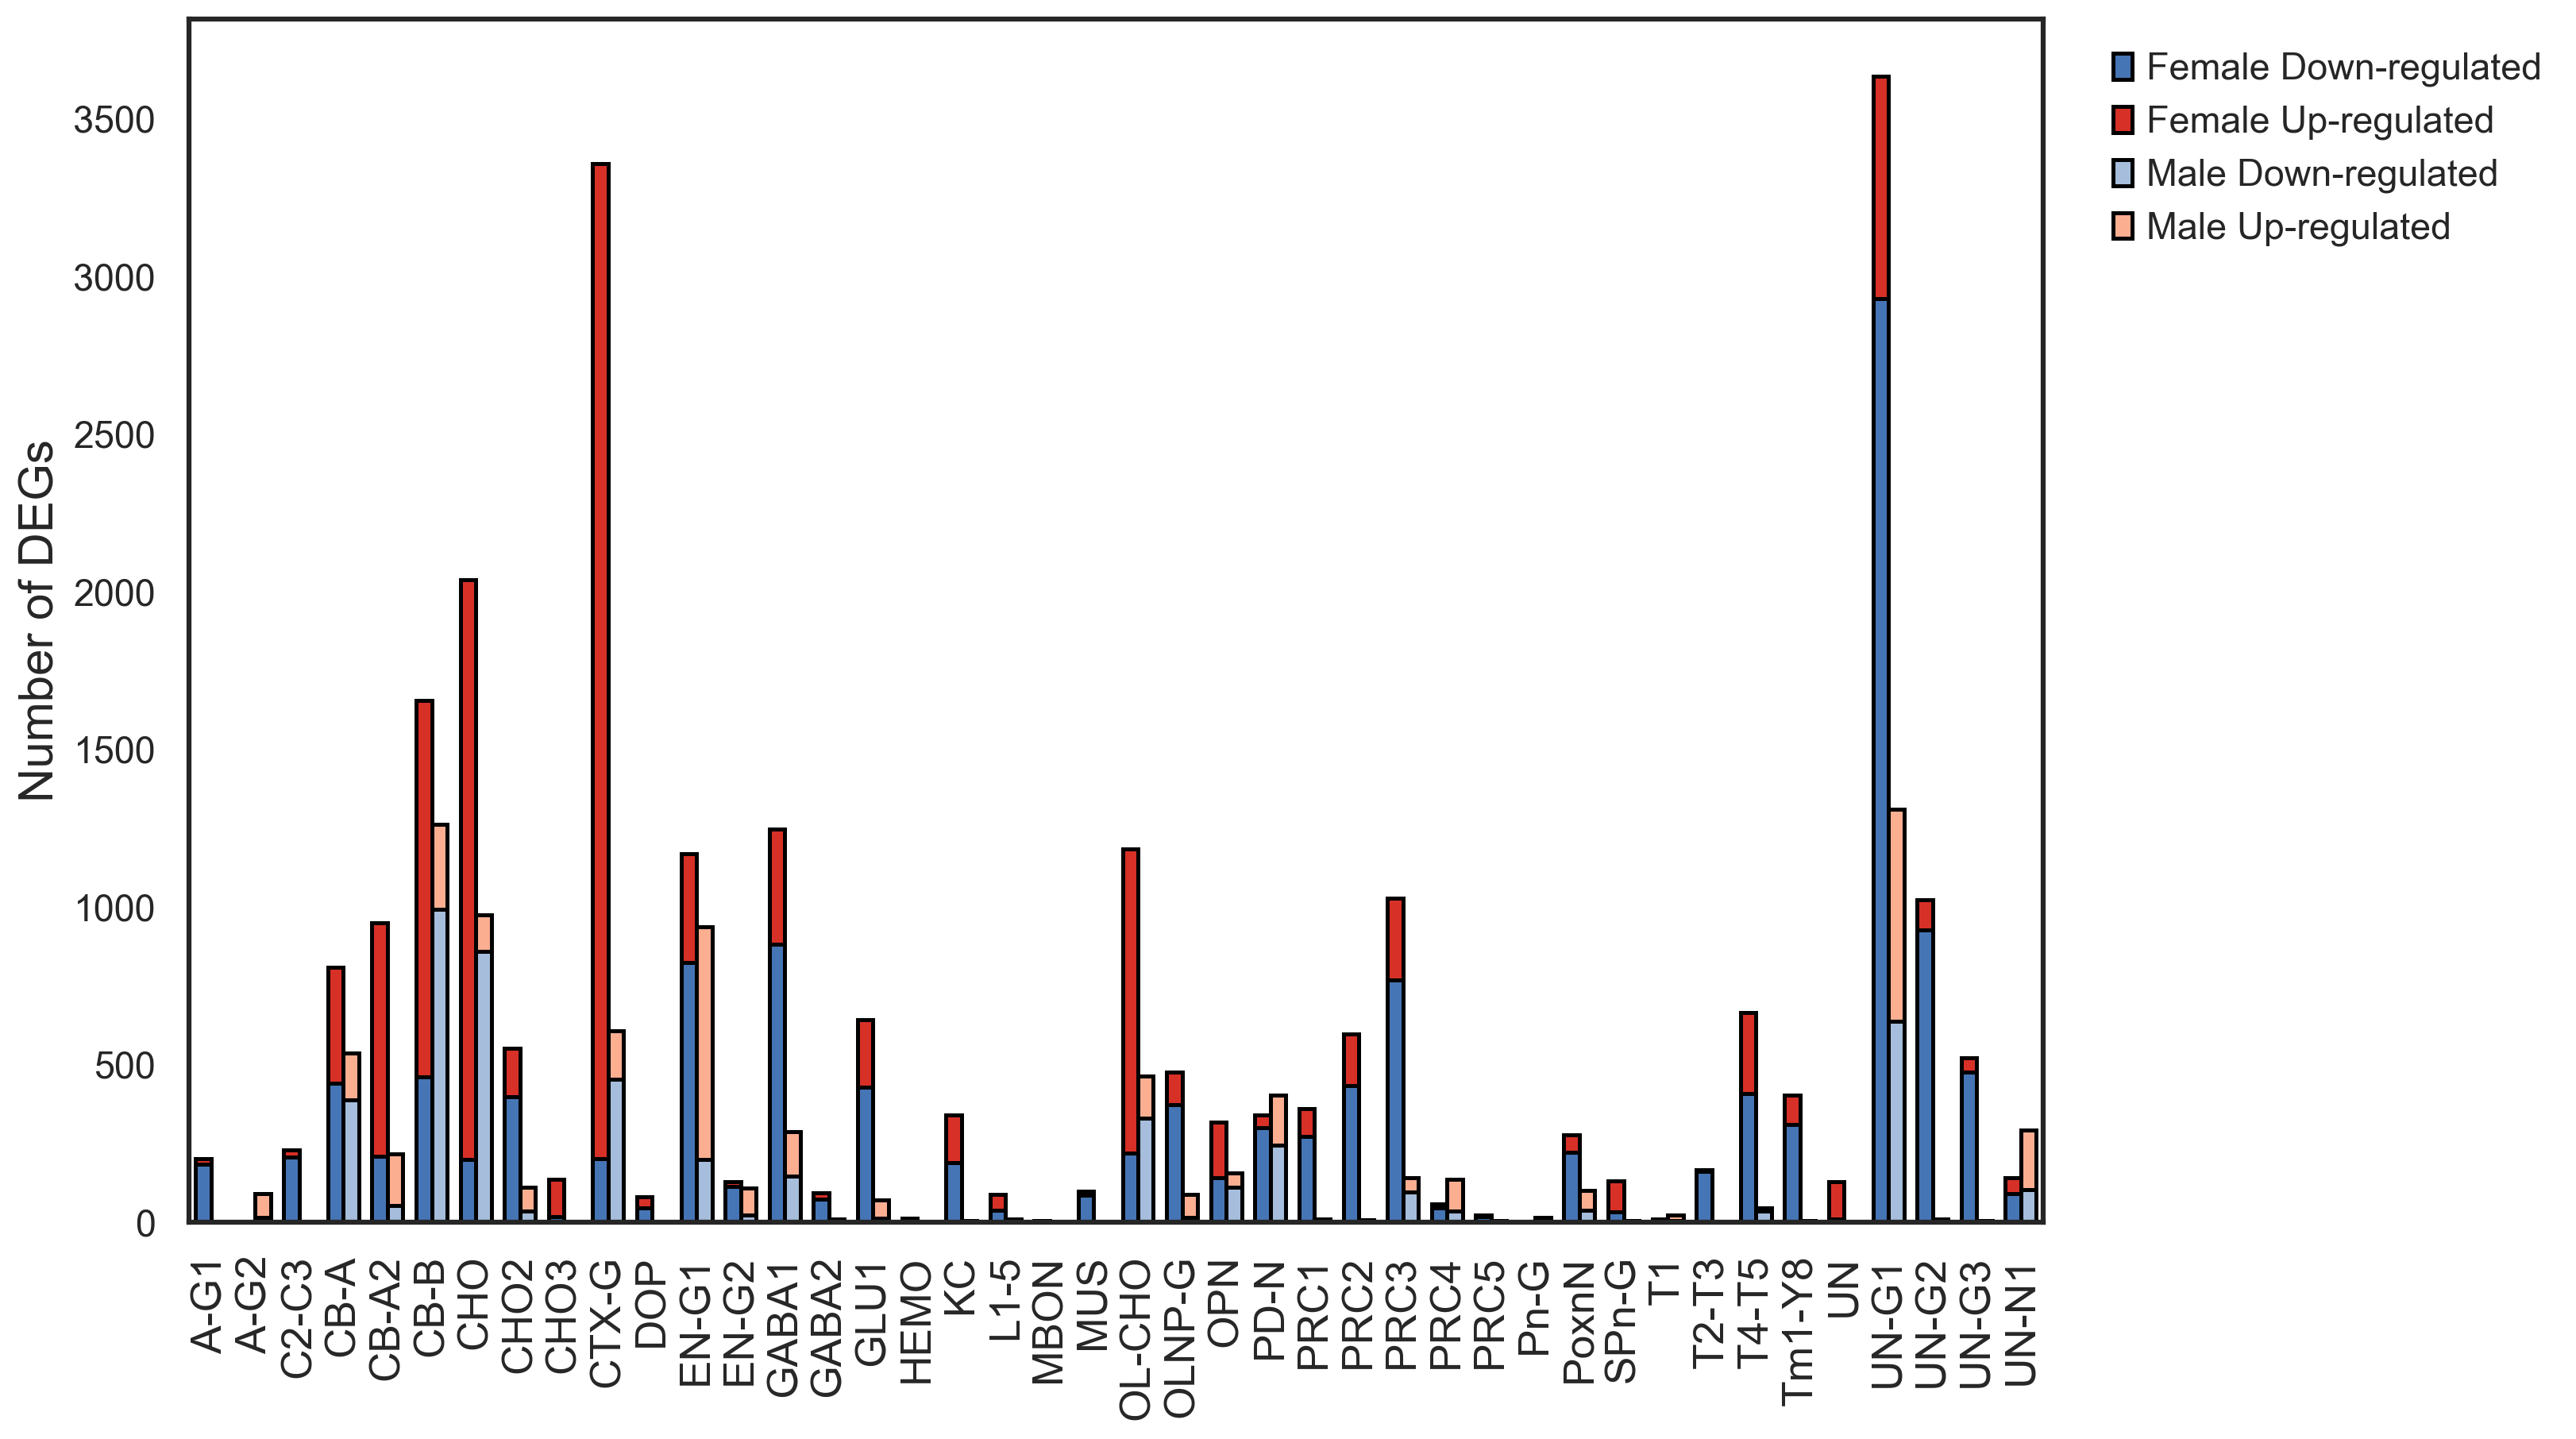

In [43]:
file_female = "C:/Users/Student/Desktop/GerardoIga/2025/Drosophila/Manuscript_1/Tables/Female_DEG_by_CellType_adjusted.xlsx"
file_male = "C:/Users/Student/Desktop/GerardoIga/2025/Drosophila/Manuscript_1/Tables/Male_DEG_by_CellType_adjusted.xlsx"
sheets_female = pd.read_excel(file_female, sheet_name=None)
sheets_male = pd.read_excel(file_male, sheet_name=None)

def summarize_DEGs(sheets, sex_label):
    summary = []
    for celltype, df in sheets.items():
        up = (df['Category'].str.lower() == 'up').sum()
        down = (df['Category'].str.lower() == 'down').sum()
        summary.append({
            'CellType': celltype,
            f'{sex_label}_Up': up,
            f'{sex_label}_Down': down
        })
    return pd.DataFrame(summary)

female_summary = summarize_DEGs(sheets_female, 'Female')
male_summary = summarize_DEGs(sheets_male, 'Male')

merged = pd.merge(female_summary, male_summary, on='CellType', how='outer').fillna(0)
merged = merged.set_index('CellType').astype(int)

celltypes = merged.index.tolist()
x = np.arange(len(celltypes))
bar_width = 0.35

female_up = merged['Female_Up']
female_down = merged['Female_Down']
male_down = merged['Male_Down']
male_up = merged['Male_Up']
fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(x - bar_width/2, female_down, bar_width, label='Female Down-regulated', color='#4575b4', edgecolor='black')
ax.bar(x - bar_width/2, female_up, bar_width, bottom=female_down, label='Female Up-regulated', color='#d73027', edgecolor='black')

ax.bar(x + bar_width/2, male_down, bar_width, label='Male Down-regulated', color='#a6bddb', edgecolor='black')
ax.bar(x + bar_width/2, male_up, bar_width, bottom=male_down, label='Male Up-regulated', color='#fcae91', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(celltypes, rotation=90, fontsize=16)
ax.set_ylabel('Number of DEGs', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(-0.5, len(celltypes) - 0.5)

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=14, frameon=False)

plt.tight_layout()
plt.show()
